# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Submission of Alexander Noll, Karma Tarap, Christian Kaas, and Thomas Kulalert**

<div class="answer-separator">
------------------------
</div>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

1.5. Plot the cross-entropy loss on the training set as a function of iteration.

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

1.6. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

1.7. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

1.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

<div class="answer-separator">
------------------------
</div>

>**1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).**

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
print("Training set contains {} examples".format(len(mnist_trainset)))

Training set contains 60000 examples


In [4]:
print("Testing set contains {} examples".format(len(mnist_testset)))

Testing set contains 10000 examples


In [5]:
print("Dimensions of each image is: {}".format(mnist_trainset[0][0].numpy().shape))

Dimensions of each image is: (1, 28, 28)


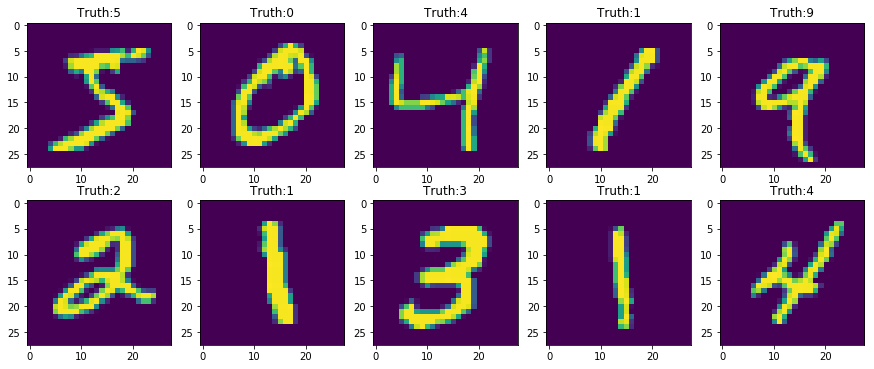

In [6]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

plt.title("10 samples from MNIST")
for i in range(10):
    img,lbl = mnist_trainset[i][0].numpy().reshape(28, 28),mnist_trainset[i][1].numpy()
    axs[i].imshow(img)
    axs[i].set_title("Truth:" + str(lbl))

>**1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.**

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

In [7]:
## Adapted from labs 4
from torch.utils.data.sampler import SubsetRandomSampler
## From labs
## define our indices -- keep 10k as validation, the remaining 50k as training
indices = list(range(len(mnist_trainset)))
split = 10000

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))


train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(mnist_trainset, 
                batch_size=50, sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(mnist_trainset, 
                batch_size=1, sampler=validation_sampler)

test_loader = torch.utils.data.DataLoader(dataset=mnist_testset, 
                                          batch_size=1,
                                          shuffle=False)

>**1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.**

In [8]:
# Adapted from Lab 3
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    
#input_dim = 28*28 
#output_dim = 10 #Number of classes

#model = LogisticRegression(input_dim, output_dim)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01) 

The logistic regression model and cross entropy loss function will be defined in the MNISTnet class

>**1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.**

In [23]:
class Prediction:
    def __init__(self, prediction, truth, image=None):
        self.image = image
        self.prediction = prediction
        self.truth = truth
        
class MNISTnet:
    def __init__(self, learning_rate=0.1, λ=0.01):
      
        self.model = LogisticRegression(28*28, 10)

        #Weight decay is the L2 regularazation parmeter
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=λ) 
        
        #Cross entropy computes softmax internally
        self.criterion = nn.CrossEntropyLoss()  

    
    def test(self, truth_set = validation_loader):
        correct, total = 0, 0
        self.missclassified = [] #for debug
        self.missclassified_examples = []
        
        for images, labels in truth_set:
            images_ = images.view(-1, 28*28).requires_grad_()

            # Forward pass to get results
            outputs = self.model(images_)

            # Predicted is most likely class
            _, predicted = torch.max(outputs.data, 1)
            
            
            # Total number of labels
            total += labels.size(0)

            # For batch size > 1, explictily loop
            for i in range(labels.size(0)):
                if predicted[i] == labels[i]:
                    correct += 1
                #else:
                #  self.missclassified.append(Prediction(image=None,prediction=predicted[i].item(),truth=labels[i].item()))
                #  #self.missclassified.append(Prediction(image=None if len(self.missclassified) < 20 else images[i],prediction=predicted[i].item(),truth=labels[i].item()))
                #  if len(self.missclassified) < 20: #Store missclassified for debug, only 20 examples
                #    self.missclassified_examples.append(Prediction(image=images[i],prediction=predicted[i].item(),truth=labels[i].item()))


          
        self.accuracy = 100 * correct / total
        return self
        
        
    def train(self, num_epochs=10, train_set=train_loader):
        
        #Required for plotting
        self.iteration_loss = np.empty(1)
        self.epoch_accuracy = []
        
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_set):
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass
                outputs = self.model(images)
                labels = labels

                # Softmax cross-entropy loss
                loss = self.criterion(outputs, labels)
                
                # Store loss for plotting
                self.iteration_loss = np.append(self.iteration_loss, loss.detach().numpy())

                # Zero gradients, perform a backward pass, and update the weights.
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
            accuracy = self.test().accuracy
            self.epoch_accuracy.append(accuracy)
            print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
        print('-'*55)  
        return self
    
    
    def plot_loss(self,title = "Cross-Entropy loss on training set"):
        plt.title(title)
        plt.plot(list(range(len(self.iteration_loss))),self.iteration_loss)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
    
    
    def plot_accuracy(self, title = "Classification accuracy of validation set at each epoch"):
        plt.title(title)
        plt.plot(list(range(len(self.epoch_accuracy))),self.epoch_accuracy)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        #plt.ylim(80, 100)
        plt.xticks(np.arange(0, len(self.epoch_accuracy), step=1))
        plt.show()
        
        
        

In [27]:
np.empty(0)

array([], dtype=float64)

In [24]:
x = MNISTnet()  
%time _ = x.train()

Epoch: 0. Loss: 0.3219741880893707. Accuracy: 89.31
Epoch: 1. Loss: 0.4733220636844635. Accuracy: 89.48
Epoch: 2. Loss: 0.33824294805526733. Accuracy: 89.76
Epoch: 3. Loss: 0.42749541997909546. Accuracy: 89.77


KeyboardInterrupt: 

>**1.5. Plot the cross-entropy loss on the training set as a function of iteration.**

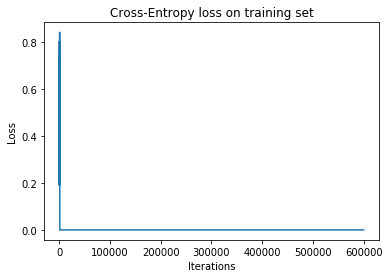

In [16]:
x.plot_loss()

>**1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.**

In [ ]:
x.plot_accuracy()
del x

>**1.7. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.**

In [ ]:
lambdas = [0.1, 0.01, 0.001, 0.0001, 0.00001]


for l in lambdas:
  model = MNISTnet(λ = l).train(num_epochs= 15)
  model.plot_loss("Classification loss of train set at each epoch (λ={})".format(l))
  model.plot_accuracy("Classification accuracy of train set at each epoch (λ={})".format(l))
  


>**1.8. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?**

In [5]:
del model

NameError: ignored

In [8]:
model = MNISTnet(λ = 0.0001).train(num_epochs=15)
train_accuracy = model.test(truth_set=train_loader).accuracy
print("Accuracy: {} on Train set when λ = 0.0001".format(train_accuracy))
test_accuracy = model.test(truth_set=test_loader).accuracy
print("Accuracy: {} on Test set when λ = 0.0001".format(test_accuracy))

Epoch: 0. Loss: 0.5785112977027893. Accuracy: 89.86
Epoch: 1. Loss: 0.26744136214256287. Accuracy: 90.87
Epoch: 2. Loss: 0.2881391644477844. Accuracy: 91.15
Epoch: 3. Loss: 0.10597855597734451. Accuracy: 91.39
Epoch: 4. Loss: 0.2172984629869461. Accuracy: 91.26
Epoch: 5. Loss: 0.2081415057182312. Accuracy: 91.44
Epoch: 6. Loss: 0.16095227003097534. Accuracy: 91.73
Epoch: 7. Loss: 0.12675540149211884. Accuracy: 91.67
Epoch: 8. Loss: 0.2342110425233841. Accuracy: 91.8
Epoch: 9. Loss: 0.3185988664627075. Accuracy: 91.62
Epoch: 10. Loss: 0.1680285632610321. Accuracy: 91.71
Epoch: 11. Loss: 0.10691256821155548. Accuracy: 91.87
Epoch: 12. Loss: 0.3218636214733124. Accuracy: 91.63
Epoch: 13. Loss: 0.38116851449012756. Accuracy: 91.75
Epoch: 14. Loss: 0.3022955656051636. Accuracy: 91.85
-------------------------------------------------------
Accuracy: 92.698 on Train set when λ = 0.0001
Accuracy: 92.28 on Test set when λ = 0.0001


>**1.9. What classes are most likely to be misclassified? Plot some misclassified training and test set images.**

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

#Source:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

NameError: ignored

In [7]:
predicted = [model.missclassified[i].prediction for i in range(len(model.missclassified))]
actual = [model.missclassified[i].truth for i in range(len(model.missclassified))]

# Compute confusion matrix
cnf_matrix = confusion_matrix(actual,predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=list(range(10)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: ignored

In [0]:
def plot_images(obj,num=9):
    for i in range(1,num+1):
        plt.subplot(3,3,i)
        img=obj.missclassified_examples[i].image
        plt.title("Predicted: {}, Truth: {}".format(obj.missclassified_examples[i].prediction,obj.missclassified_examples[i].truth))
        plt.imshow(img.numpy().reshape(28,28))
    plt.tight_layout()

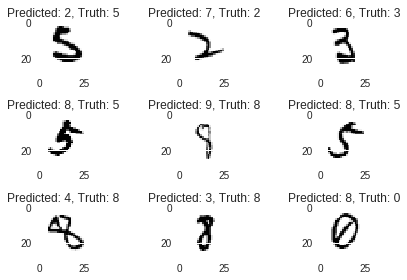

In [12]:
train_peek = model.test(truth_set=train_loader)
plot_images(train_peek)    

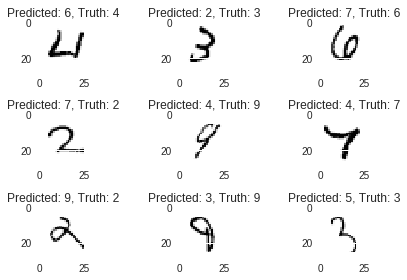

In [13]:
test_peek = model.test(truth_set=test_loader)
plot_images(train_peek)   
del model

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}\right]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.


**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

<div class="answer-separator">
------------------------
</div>